<a href="https://colab.research.google.com/github/B4Farouk/smpl-dr-clip/blob/main/sanity_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies


### torch, torchvision

In [ ]:
# install torch and torchvision
!pip uninstall -y torchtext

!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


### pytorch3d

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'



In [ ]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [ ]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### CLIP

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1al3d3b4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-1al3d3b4


## GPU

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

## Setup

### Codebase Loading

In [ ]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 803, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 803 (delta 100), reused 175 (delta 99), pack-reused 622
Receiving objects: 100% (803/803), 74.84 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (468/468), done.


### Local Imports 

In [ ]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper


from project.optimization import OptimEnv, OptimConfig, TrackerConfig, init_weights, init_random_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test: SMPL and Rendering

In [ ]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [ ]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [10]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

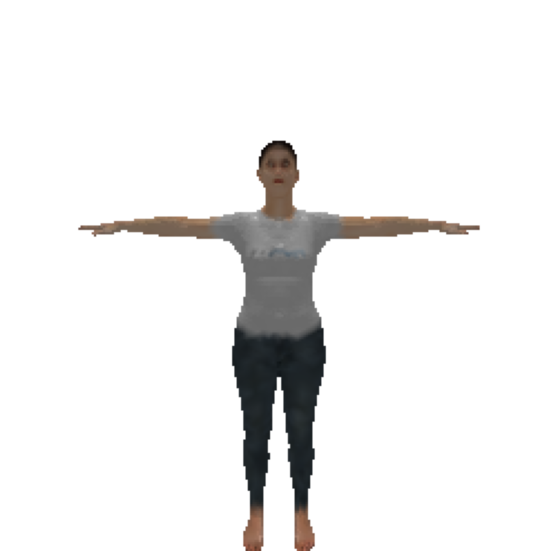

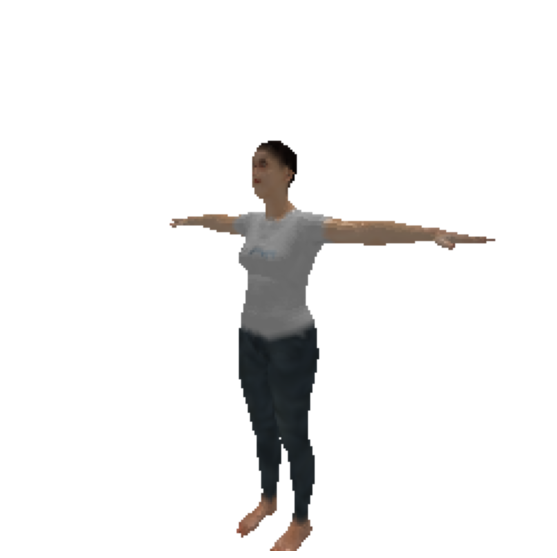

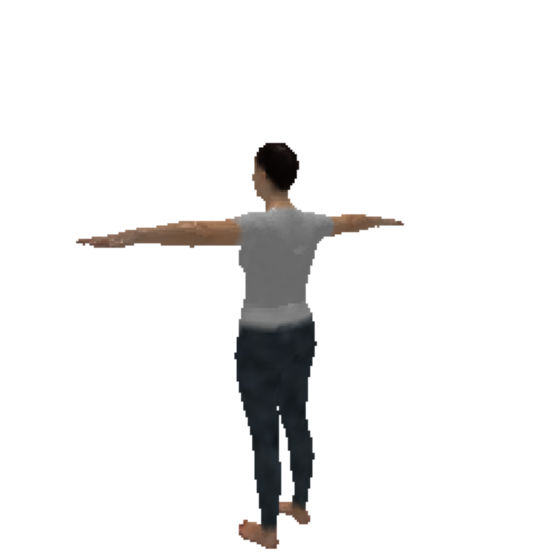

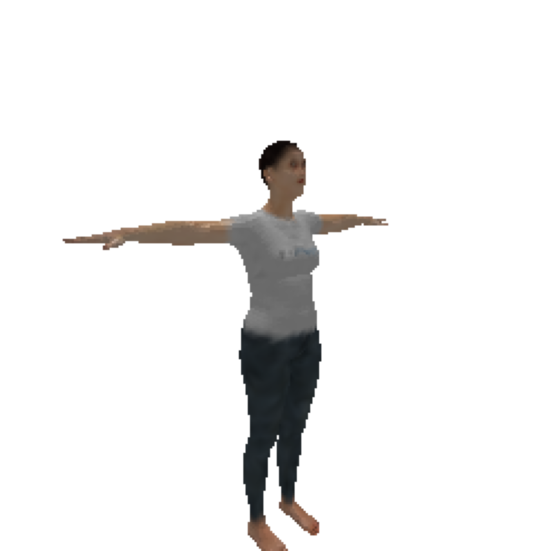

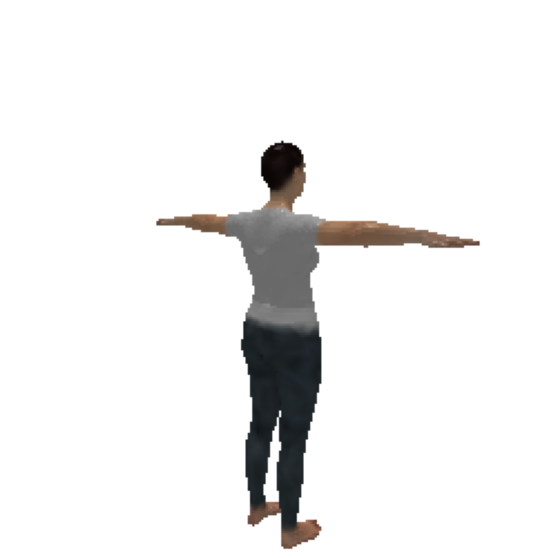

In [ ]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

float(cosine_distances.mean())

## MODELS


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769b151790>)

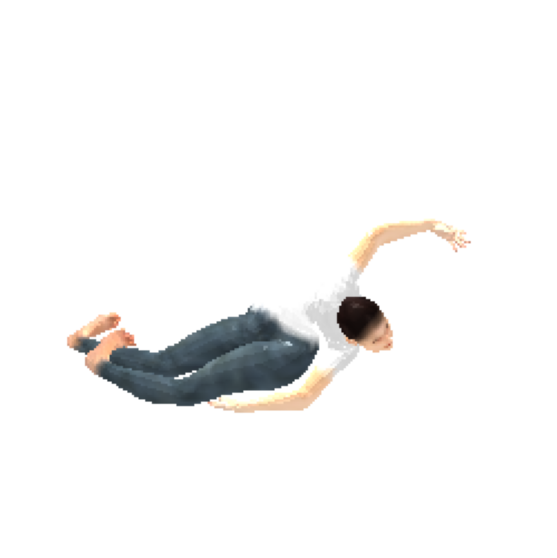

In [ ]:
pose, shape = init_random_weights(dev)
def model(pose, shape):
        return renderer.render(smpl_model.meshes(pose, shape)),False
image,_=model(pose,shape)
plot_image_t(image[0].squeeze())


### Optimization

In [ ]:


def mse_loss(x,y):
  return torch.sum(torch.sum(torch.square(x-y)))

In [ ]:


objective = lambda imgs_embs, pmt_emb: mse_loss(imgs_embs,image)
def run_optimization(model, loss_mode, n_passes=1000):
  # configs
  optimconfig = OptimConfig(loss_mode=loss_mode, loss_fn=objective)
  trackerconfig = TrackerConfig()
  # weights used in optimization
  pose, shape = init_weights(device=dev)
  # optimize with respect to the pose only
  optimenv = OptimEnv(model=model, weights=[pose], config=optimconfig) 
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, trackerconfig=trackerconfig)
  return result

def intermediate_views(result, coords):
  visu_smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
  visu_camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  visu_renderer = Renderer(cameras=visu_camera, device=dev)
  
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = visu_smpl_model.meshes(theta=pose, beta=shape)
    image = visu_renderer.render(mesh)
    plot_image_t(image.squeeze())

### Results

In [ ]:
p1_result = run_optimization(model=model, n_passes=1000,loss_mode="average-loss-on-embeddings")

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769acf2310>)

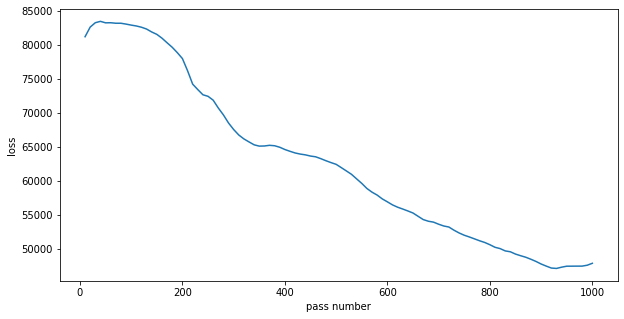

In [ ]:
plot_losses(p1_result["tracked"]["losses"])

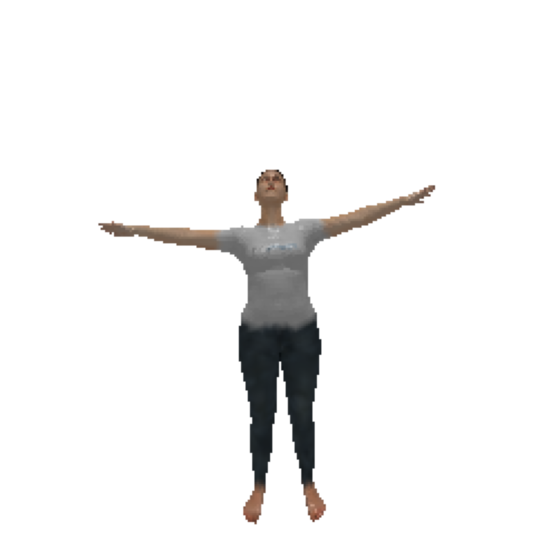

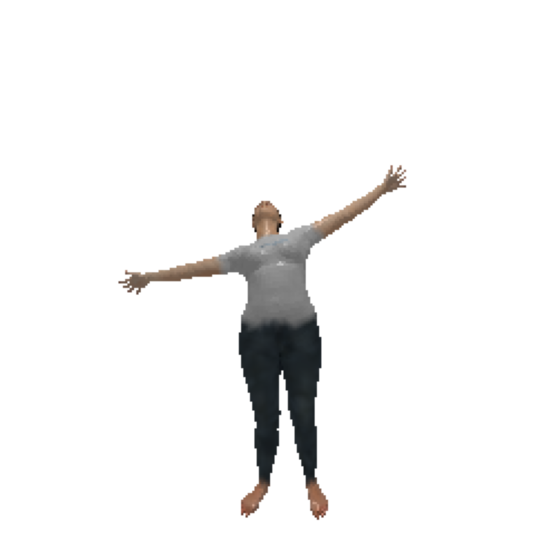

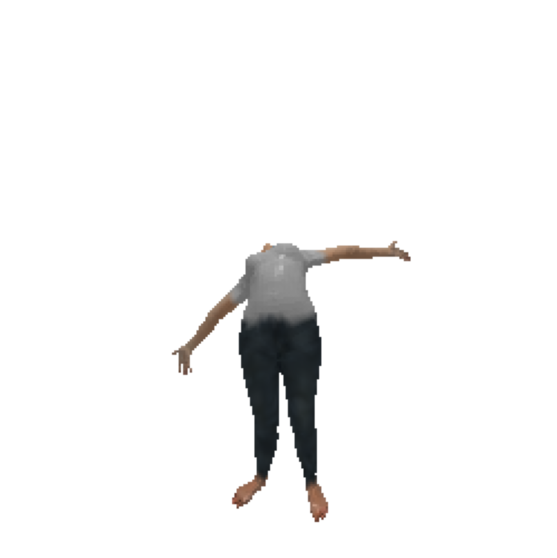

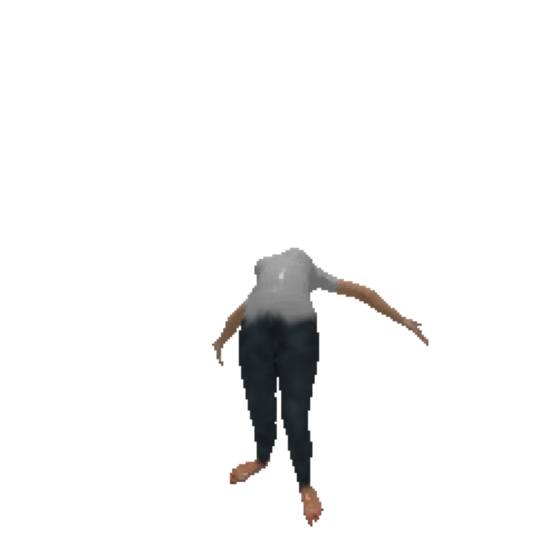

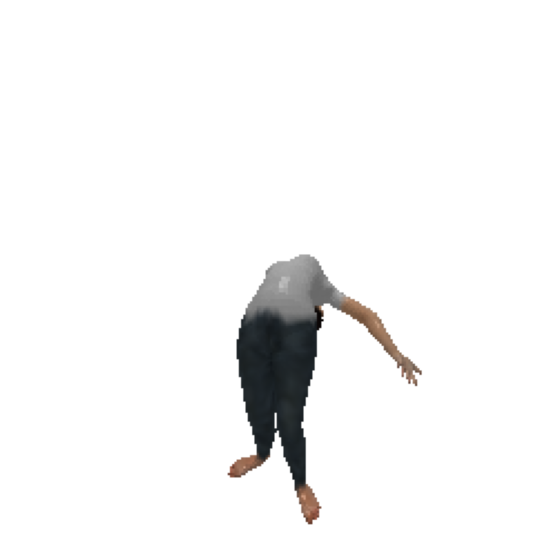

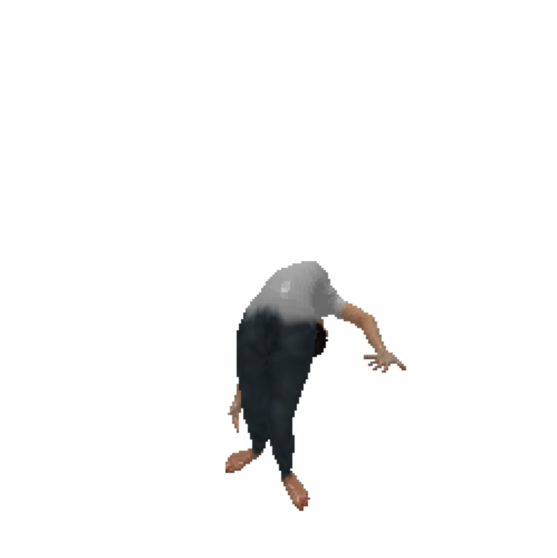

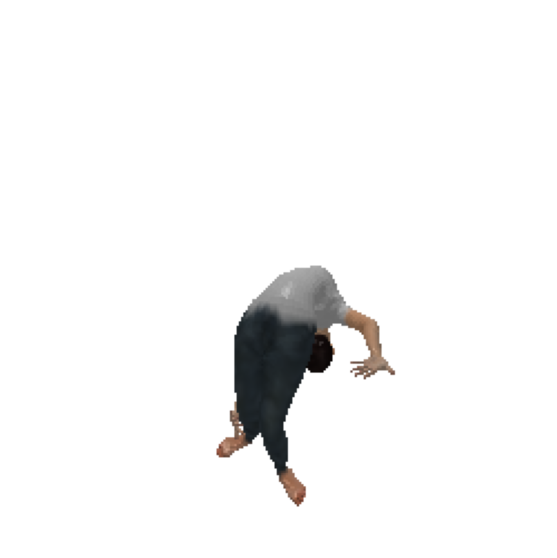

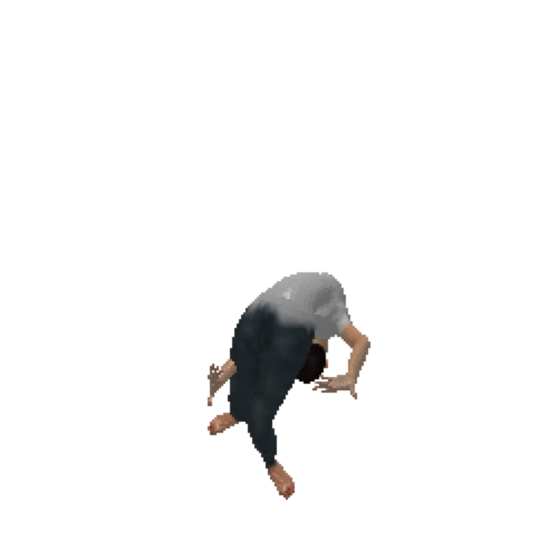

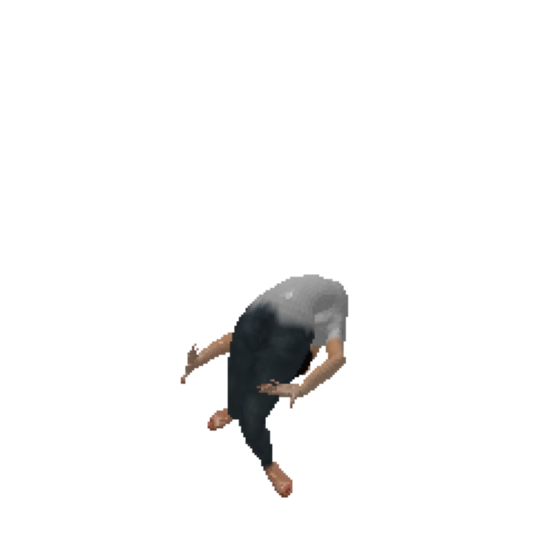

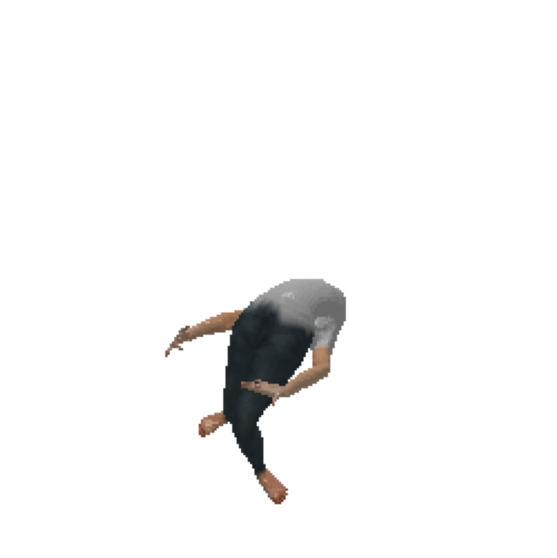

In [ ]:
intermediate_views(p1_result, coords=(2.25, 0, 10))

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769a3aa5b0>)

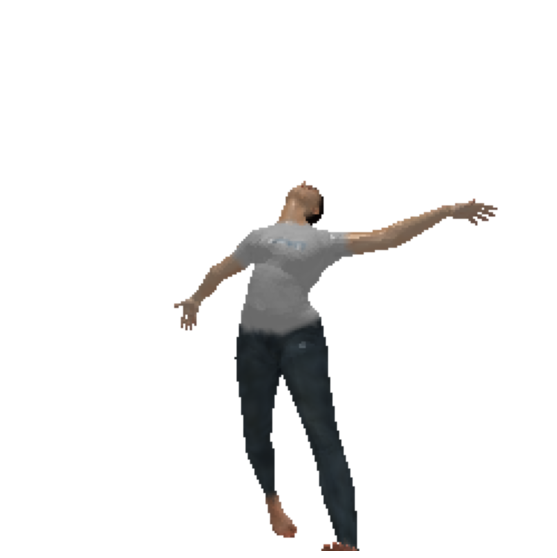

In [ ]:

pose  = torch.rand((1, 72), requires_grad=True, device=dev)-0.5 
shape = torch.ones((1, 10), requires_grad=True, device=dev)

def model(pose, shape):
        return renderer.render(smpl_model.meshes(pose, shape)),False
image,_=model(pose,shape)
plot_image_t(image[0].squeeze())

In [ ]:
p1_result = run_optimization(model=model, n_passes=1000,loss_mode="average-loss-on-embeddings")

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769a2f9fd0>)

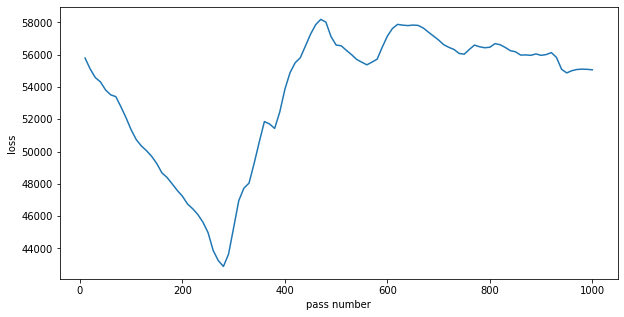

In [ ]:
plot_losses(p1_result["tracked"]["losses"])

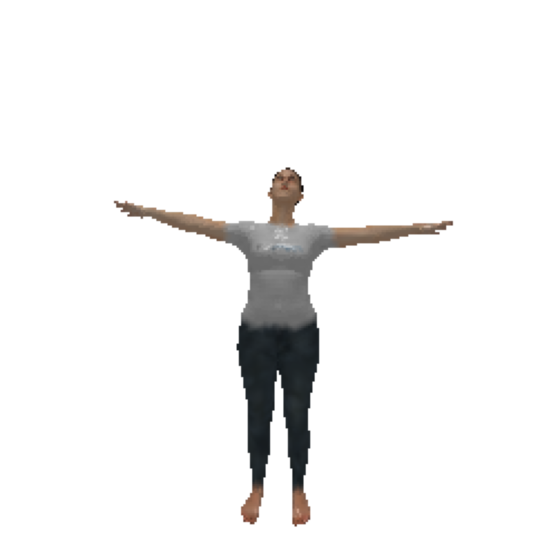

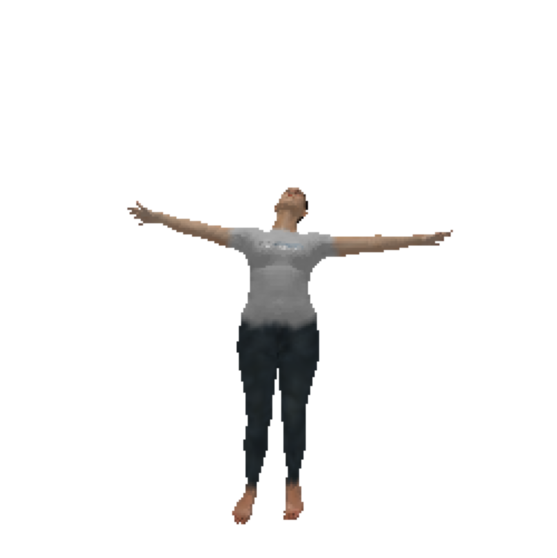

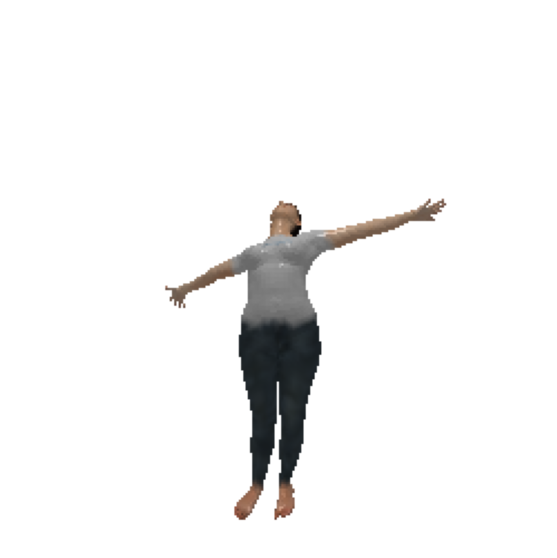

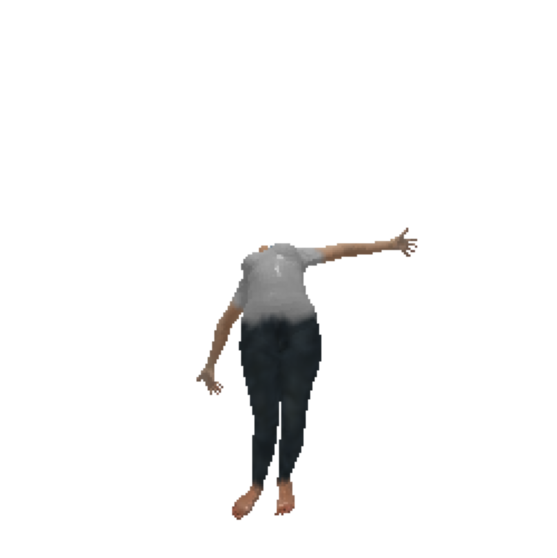

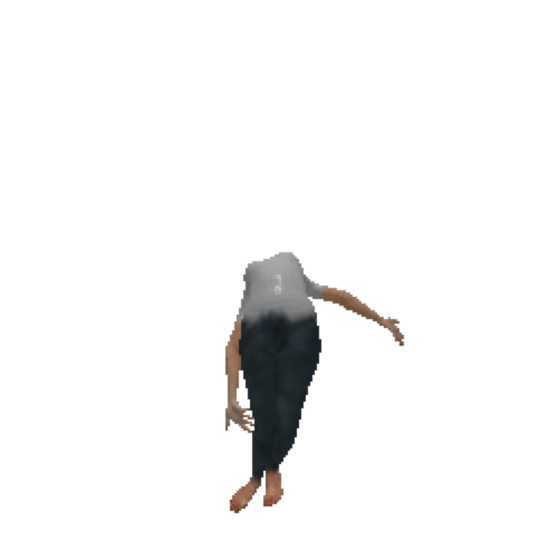

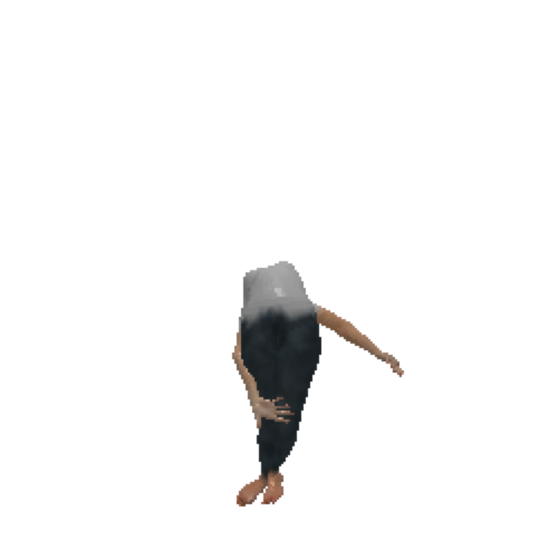

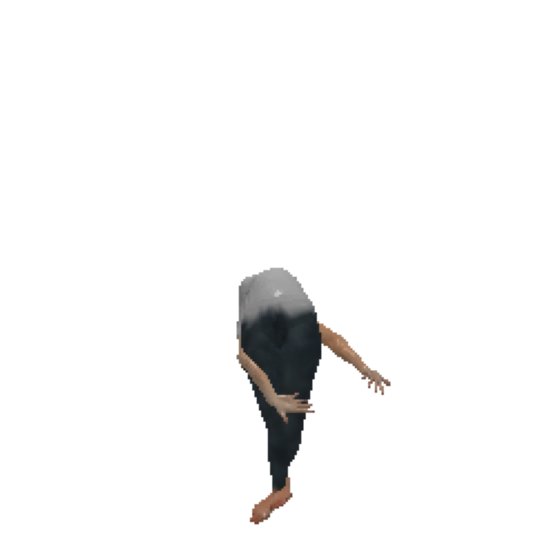

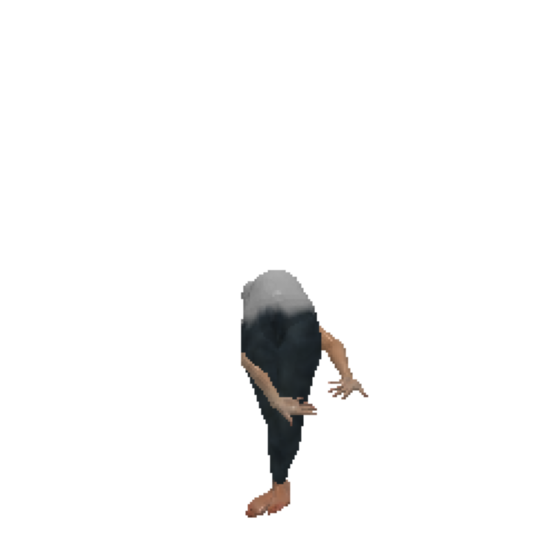

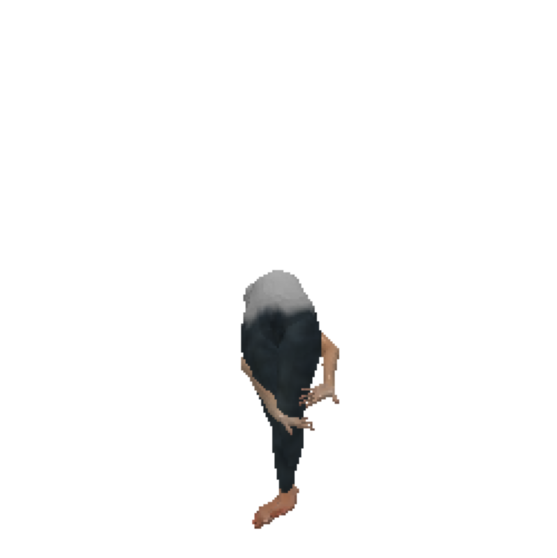

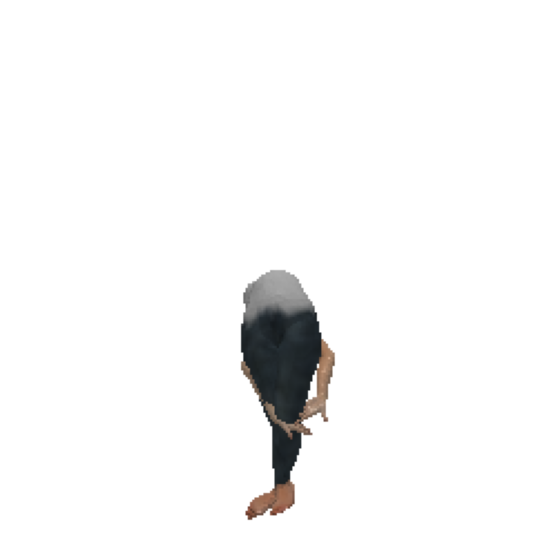

In [ ]:
intermediate_views(p1_result, coords=(2.25, 0, 10))

In [ ]:
p1_result = run_optimization(model=model, n_passes=1000,loss_mode="loss-on-average-embedding")

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f769a2be760>)

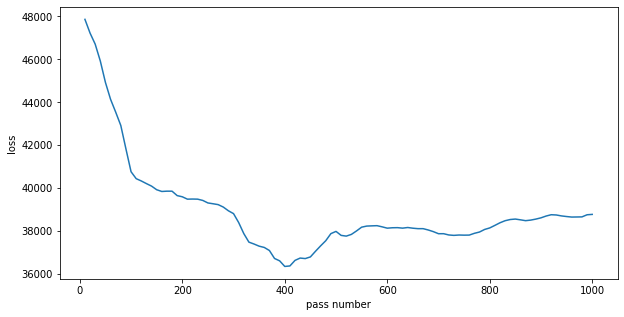

In [ ]:
plot_losses(p1_result["tracked"]["losses"])

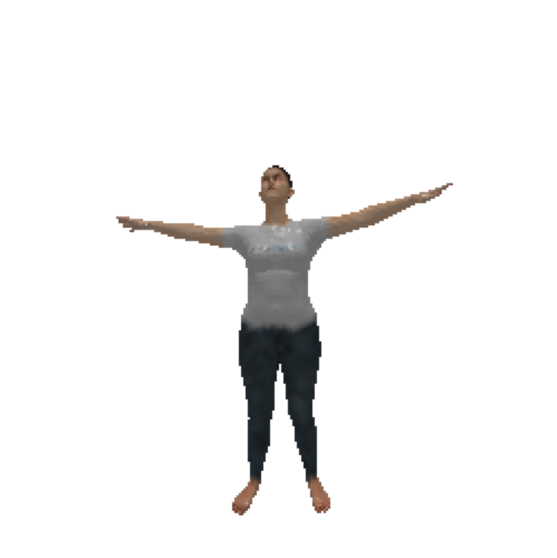

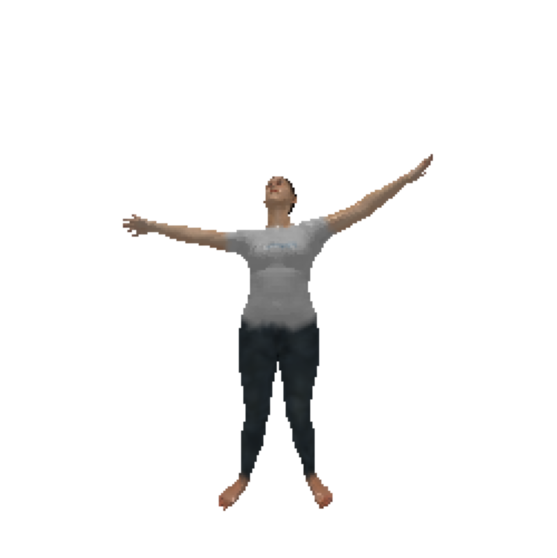

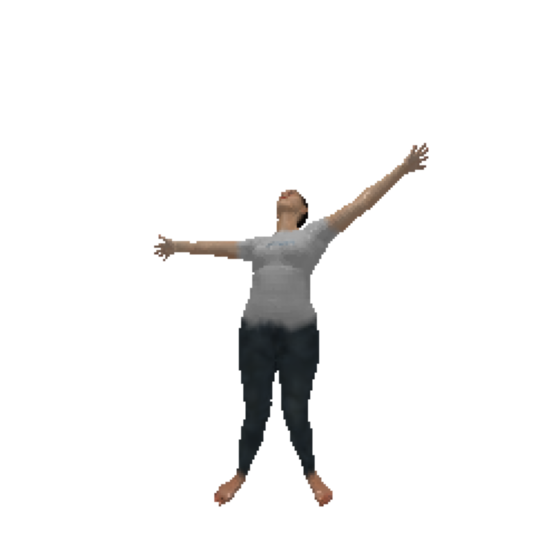

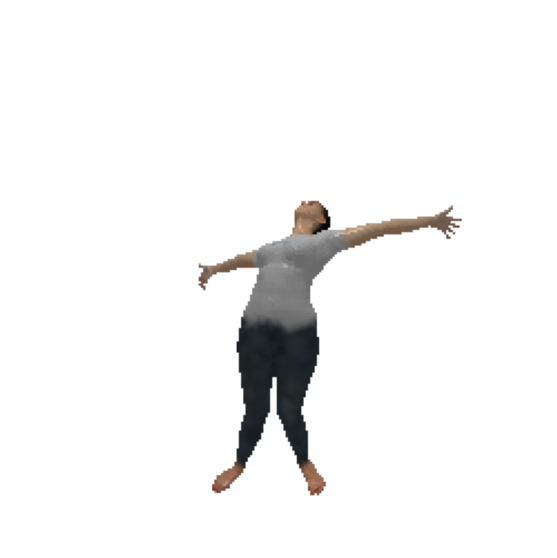

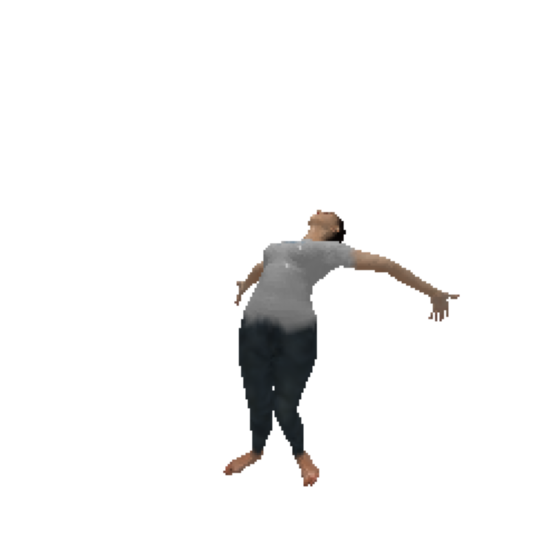

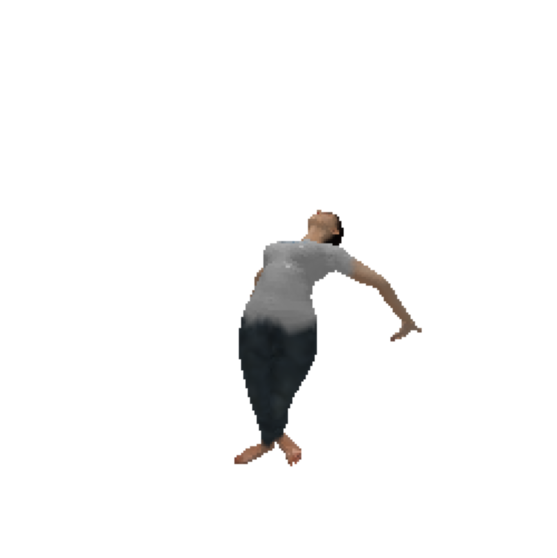

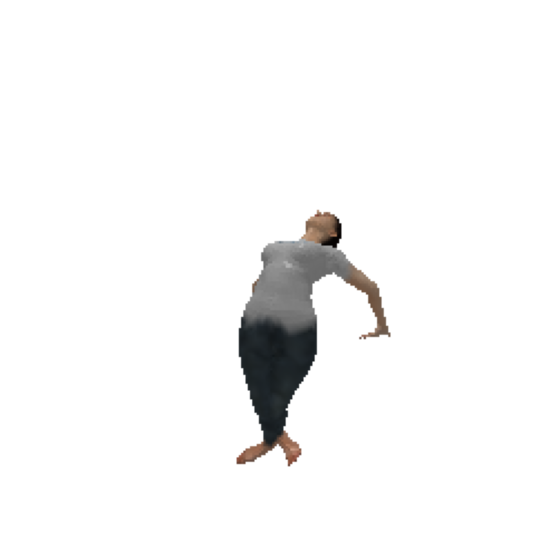

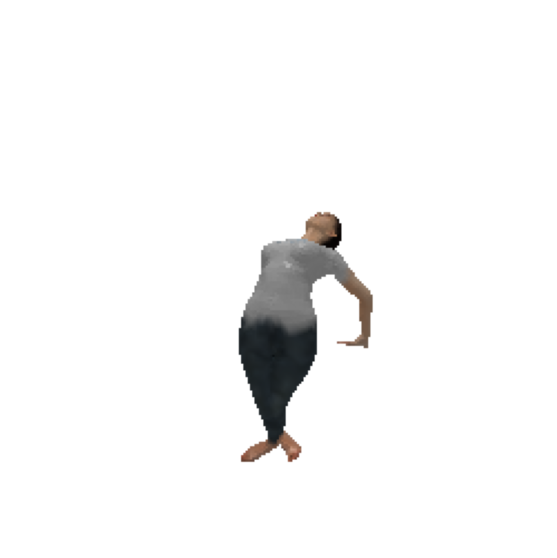

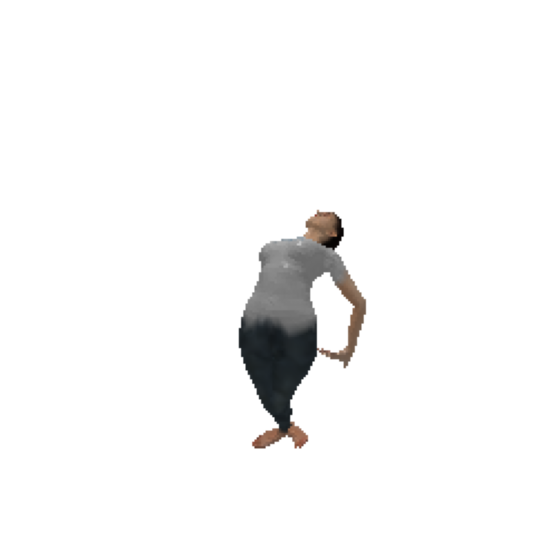

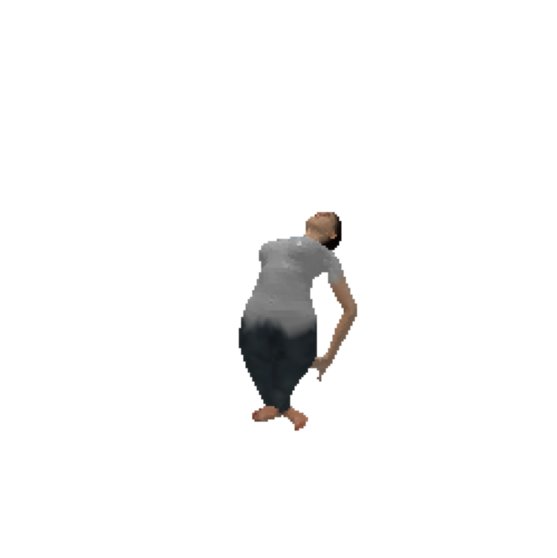

In [ ]:
intermediate_views(p1_result, coords=(2.25, 0, 10))